# Epsilon Error Chart

Here we cover the parameter variation when data size growth

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline

import sys
import time
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import svm

import multiprocessing
import tempfile
import os
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
cpuN = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions_sample.csv.gz', compression='gzip')

## Parallel Method

In [2]:
def computeCLF(X,Y,epsilon,scores,clf_name):
    
    classifiers = outliers.getClassifiers(epsilon)
    
    try:
        clf = classifiers[clf_name]
        if clf_name == 'LOF':
            y_pred = clf.fit_predict(X)
        else:
            clf.fit(X)
            y_pred = clf.predict(X)

        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        f = f1_score(y_pred, Y)
        scores[int(epsilon*100)] = f
    except:
        scores[int(epsilon*100)] = 0

## ANLODIPINO Test Case

For each algorithm we run all parameter with 10 folds of ANLODIPINO data

In [3]:
folder = tempfile.mkdtemp()
score_name = os.path.join(folder, 'score')

classifiers = outliers.getRanges()

mean_ep = pd.DataFrame()
mean_f = pd.DataFrame()

med = 'ANLODIPINO'

X, Y = outliers.getPrescriptions(prescription, med)
anomalies = len(Y[Y==1])
total = len(X)

print(med + ', Size: ', total, ' Overdose: ', anomalies)

for i, (clf_name, ep_range) in enumerate(classifiers.items()):

    print(clf_name)
    
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
        
        scores_df = pd.DataFrame()
        
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
        
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 100) < div:
            continue
            
        size_idx = div * 100
        div = 1 + (size // 100)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
        
        scores = np.memmap(score_name, dtype=float, shape=(150), mode='w+')
        
        Parallel(n_jobs=cpuN)(delayed(computeCLF)(X_train, Y_train,epsilon,scores,clf_name)
                   for epsilon in ep_range)
        
        for ep in ep_range:
            idx = int(ep*100)
            scores_df.loc[clf_name,ep] = scores[idx]
        
        ep_max = scores_df.loc[clf_name].idxmax()
        mean_ep.loc[clf_name,size_idx] = float(ep_max)
        mean_f.loc[clf_name,size_idx] = scores_df.loc[clf_name].max()
        
        sys.stdout.write('('  + str(ep_max) + ',' + str(scores_df.loc[clf_name].max()) +') ')
        
        if size > 5000:
            break

    print('')

print('Done')
mean_ep

ANLODIPINO, Size:  10392  Overdose:  38
DDC-M
1/274, (0.01,0.0) 2/548, (0.01,0.0) 3/822, (0.01,0.0) 4/1096, (0.01,0.0) 5/1370, (0.01,0.0) 6/1644, (0.01,0.0) 7/1918, (0.01,0.0) 8/2192, (0.01,0.0) 9/2466, (0.01,0.0) 10/2740, (0.01,0.0) 11/3014, (0.01,0.0) 12/3288, (0.01,0.0) 13/3562, (0.01,0.0) 14/3836, (0.82,0.0647482014388) 15/4110, (0.82,0.0625) 16/4384, (0.82,0.0547112462006) 17/4658, (0.82,0.051724137931) 18/4932, (0.82,0.05) 19/5205, (0.82,0.0497237569061) 
Gau
1/274, (0.01,0.125) 2/548, (0.01,0.2) 3/822, (0.01,0.06) 4/1096, (0.01,0.078431372549) 5/1370, (0.01,0.0769230769231) 6/1644, (0.01,0.0821917808219) 7/1918, (0.01,0.0897435897436) 8/2192, (0.01,0.0888888888889) 9/2466, (0.01,0.0904522613065) 10/2740, (0.01,0.0904977375566) 11/3014, (0.01,0.0887096774194) 12/3288, (0.01,0.0933852140078) 13/3562, (0.01,0.0962962962963) 14/3836, (0.01,0.0952380952381) 15/4110, (0.01,0.0983606557377) 16/4384, (0.01,0.0922190201729) 17/4658, (0.01,0.0926430517711) 18/4932, (0.01,0.0947368421053) 

,100,300,600,900,1100,1400,1700,2000,2200,2500,2800,3100,3300,3600,3900,4200,4400,4700,5000
DDC-M,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.82,0.82,0.82,0.82,0.82,0.82
Gau,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
DDC-J,0.02,0.02,0.02,0.02,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
SVM,0.06,0.03,0.04,0.05,0.03,0.11,0.03,0.01,0.03,0.08,0.02,0.06,0.02,0.01,0.01,0.06,0.05,0.10,0.02
Cov,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
DDC-H,0.89,0.89,0.89,0.89,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.89,0.89,0.89,0.89,0.89,0.89
LOF,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01
DDC,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.92,0.92,0.92,0.92,0.92,0.92
IsoF,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.05,0.05,0.01,0.01,0.06,0.01,0.01,0.05,0.01
DDC-C,0.91,0.91,0.91,0.91,0.44,0.44,0.44,0.44,0.44,0.44,0.44,0.44,0.44,0.49,0.49,0.49,0.49,0.49,0.49


## Best Parameter Plot

Here we plot the best parameter variation for each algorithm wehn data growth

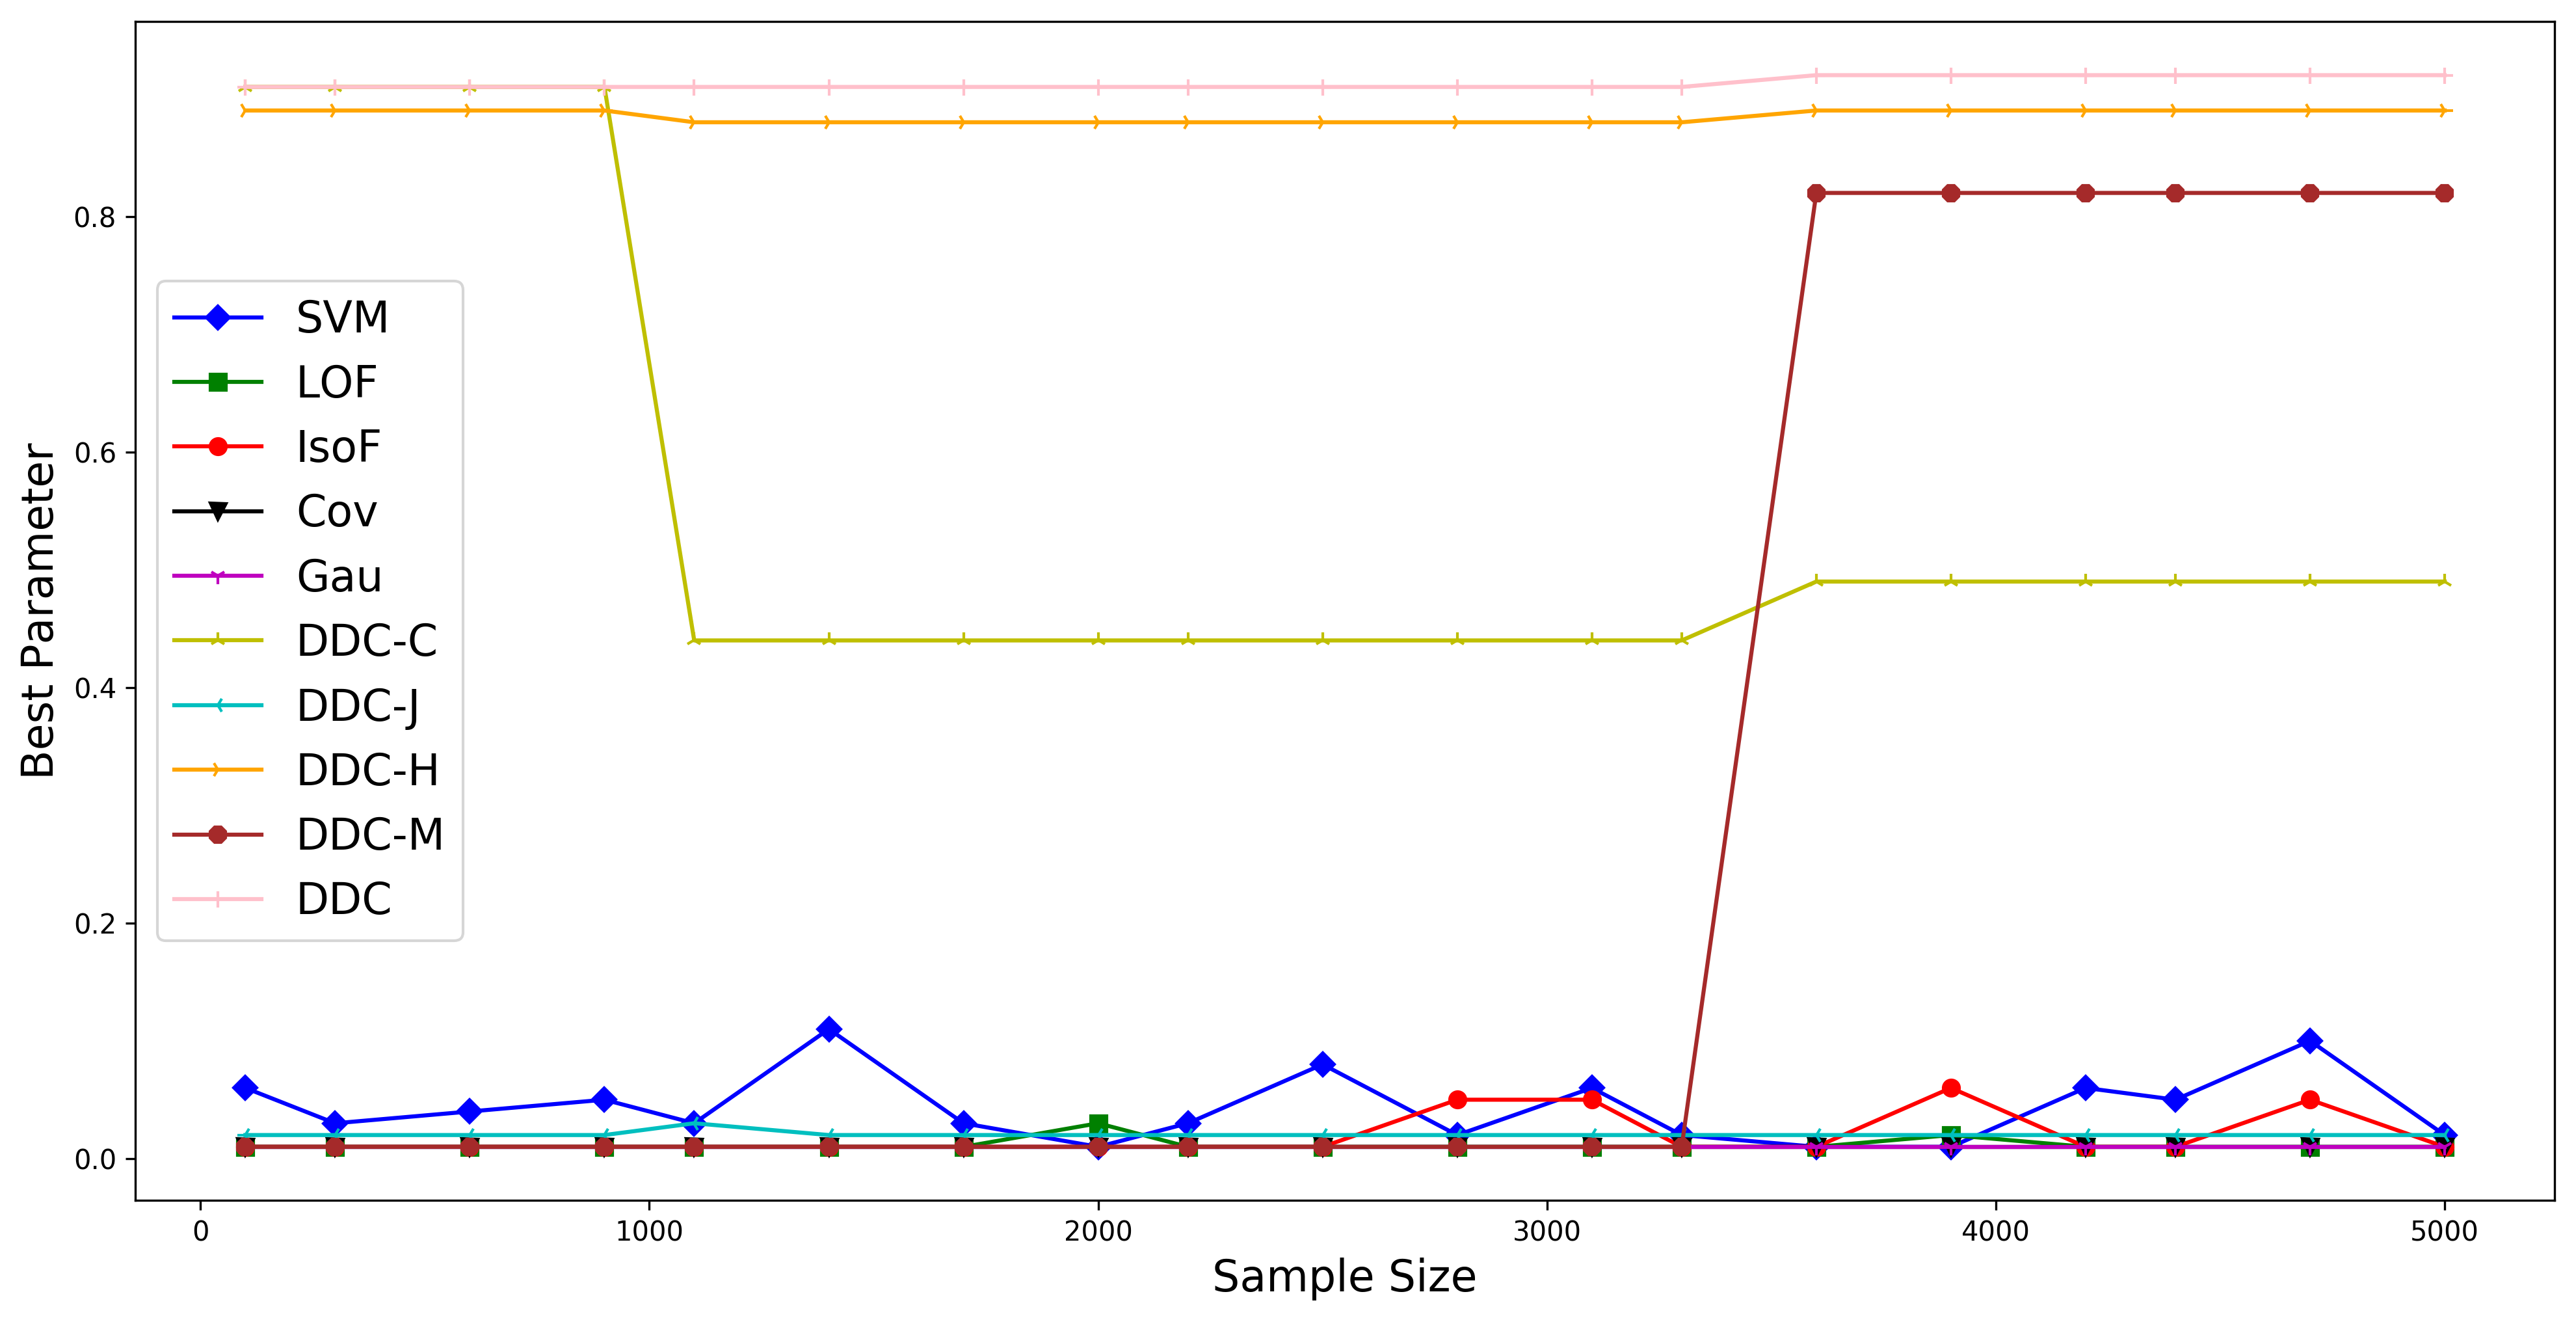

In [8]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC-M','DDC']
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'orange', 'brown', 'pink']
markers = ['D', 's', 'o', 'v', '1', '2', '3', '4', '8', '+']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_ep.columns),np.asarray(mean_ep.loc[m].values), c=colors[i],label=m,marker=markers[i])
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Best Parameter', fontsize=16)
plt.show()

## Best F-Measure Plot

Here we plot the best parameter F-Measure variation for each algorithm wehn data growth

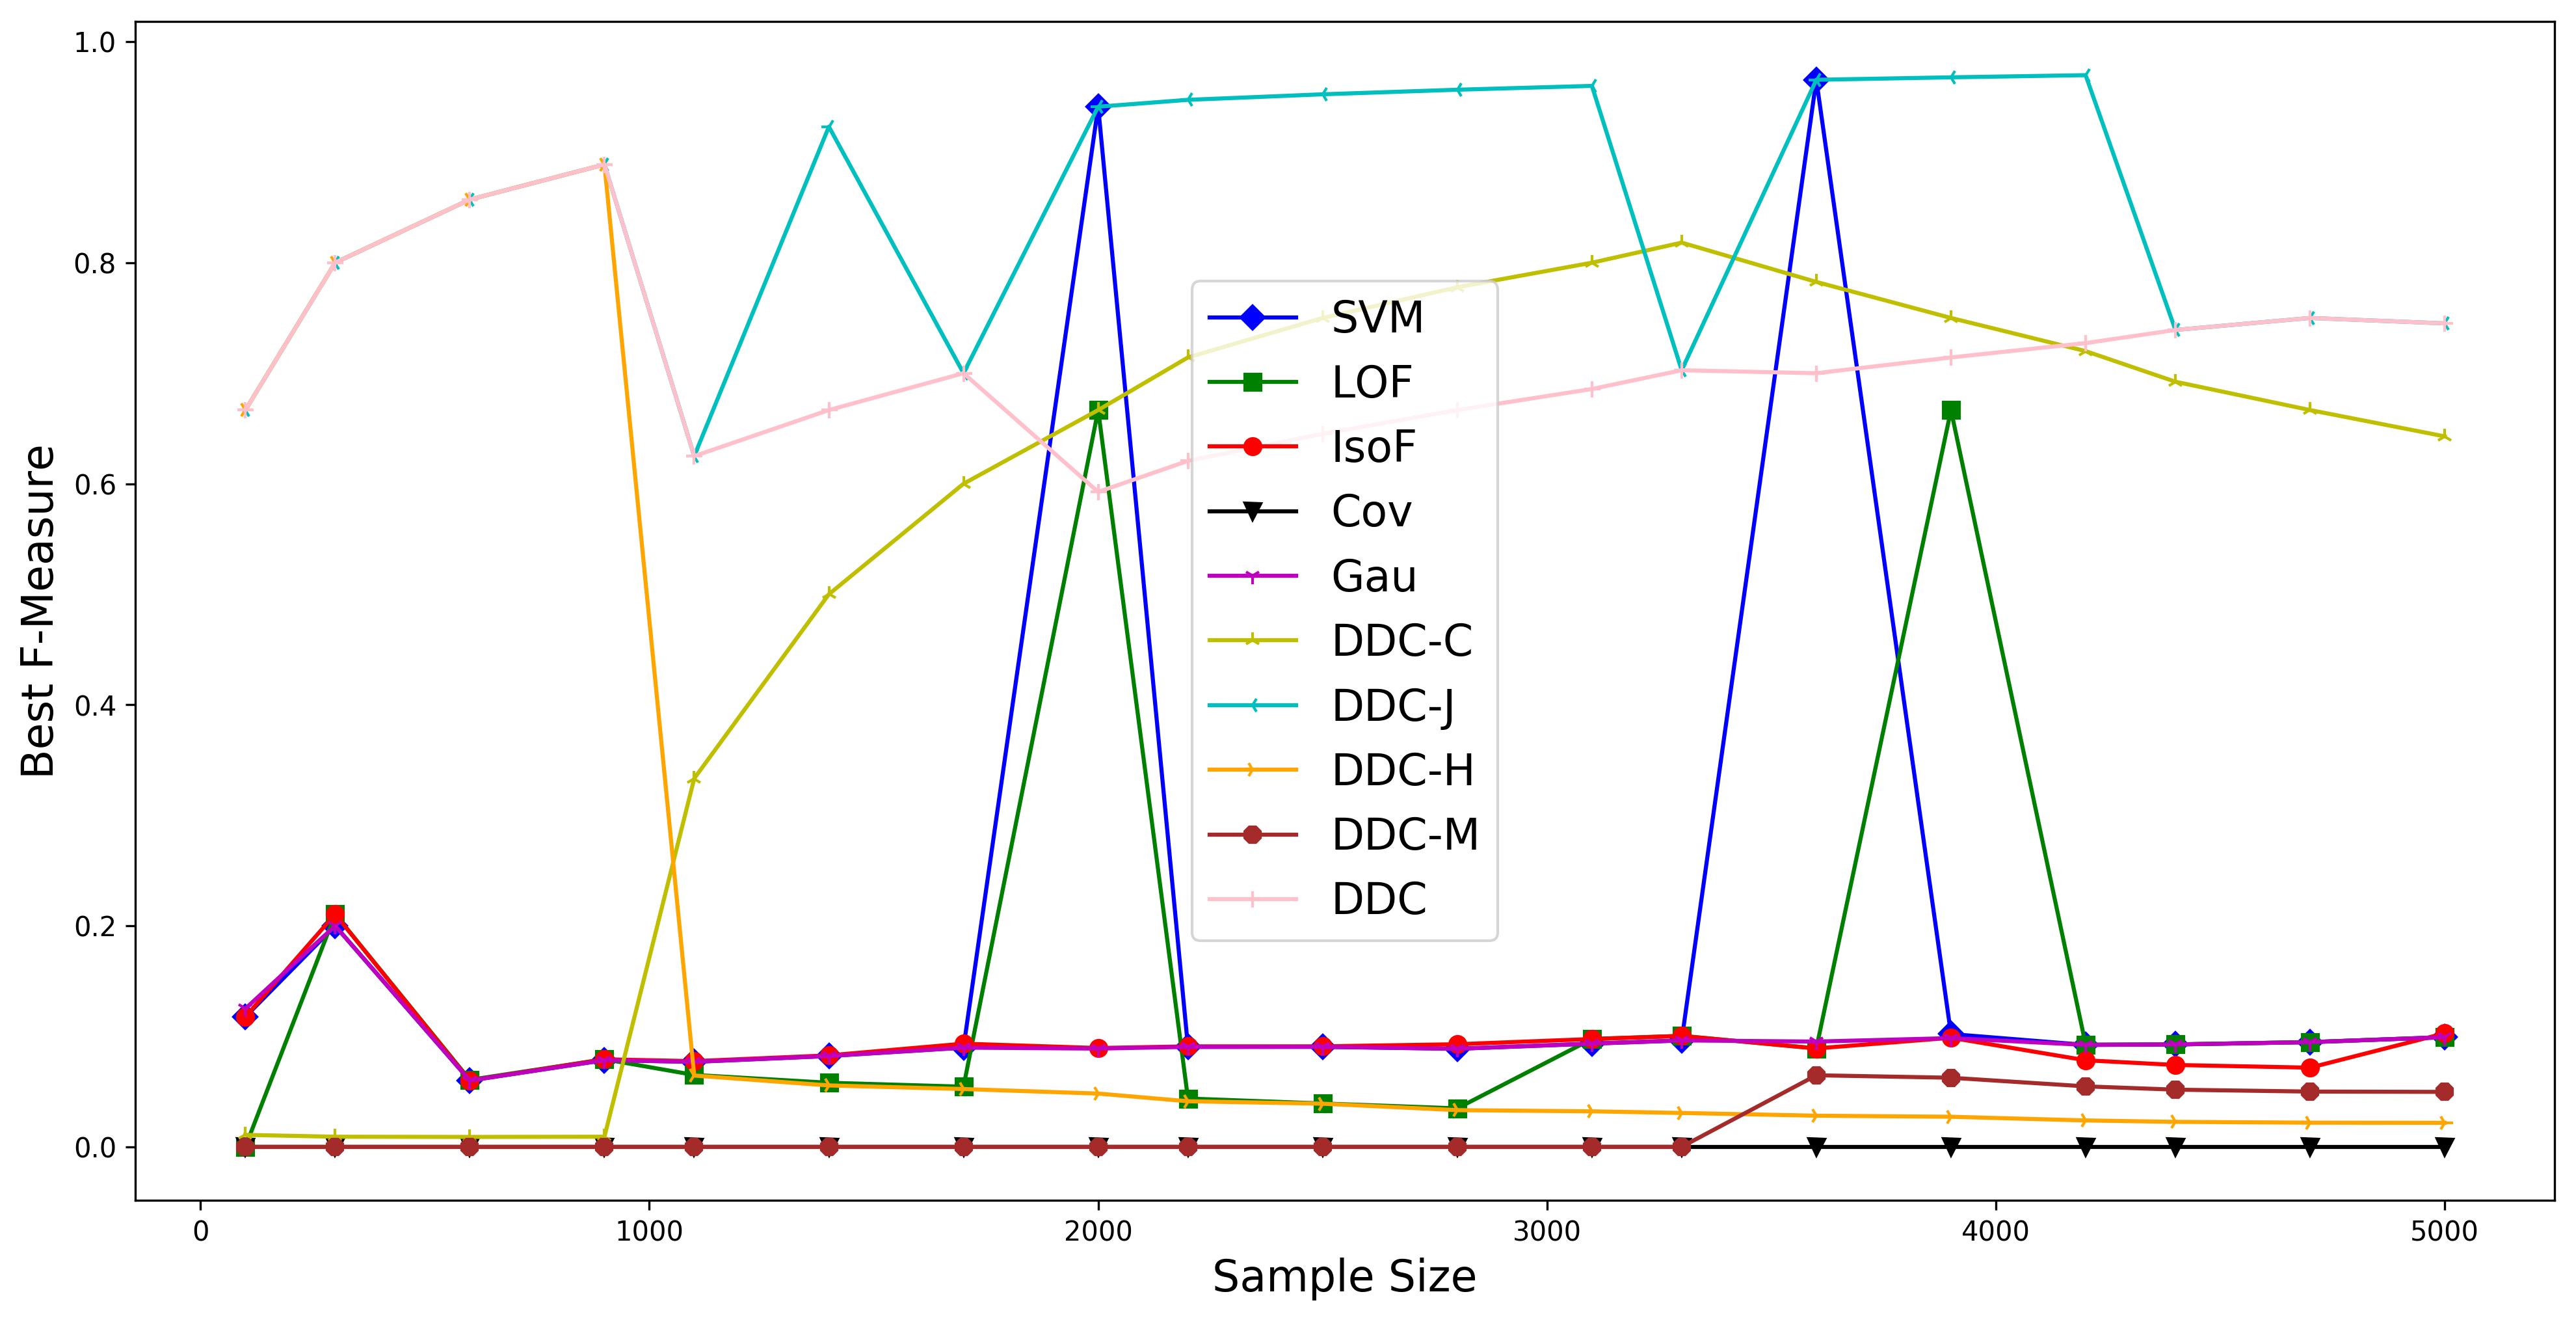

In [9]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC-M','DDC']
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'orange', 'brown', 'pink']
markers = ['D', 's', 'o', 'v', '1', '2', '3', '4', '8', '+']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_f.columns),np.asarray(mean_f.loc[m].values), c=colors[i],label=m,marker=markers[i])
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Best F-Measure', fontsize=16)
plt.show()